In [1]:
import sys
import os

# Set the main path in the root folder of the project.
sys.path.append(os.path.join('..'))

In [2]:
# Settings for autoreloading.
%load_ext autoreload
%autoreload 2

In [3]:
from src.utils.seed import set_random_seed

# Set the random seed for deterministic operations.
SEED = 42
set_random_seed(SEED)

In [4]:
import torch

# Set the device for training and querying the model.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The selected device is: "{DEVICE}"')

The selected device is: "cuda"


# Loading the data

In [5]:
import os

RAW_DATA_DIR = os.path.join('..', 'data', 'metr-la', 'raw')
PROCESSED_DATA_DIR = os.path.join('..', 'data', 'metr-la', 'processed')
PREDICTED_DATA_DIR = os.path.join('..', 'data', 'metr-la', 'predicted')

In [6]:
import pickle

# Get the data scaler.
with open(os.path.join(PROCESSED_DATA_DIR, 'scaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)

In [7]:
from src.spatial_temporal_gnn.model import SpatialTemporalGNN
from src.data.data_extraction import get_adjacency_matrix

# Get the adjacency matrix
adj_matrix_structure = get_adjacency_matrix(
    os.path.join(RAW_DATA_DIR, 'adj_mx_metr_la.pkl'))

# Get the header of the adjacency matrix and the matrix itself.
header, _, adj_matrix = adj_matrix_structure

# Get the STGNN and load the checkpoints.
spatial_temporal_gnn = SpatialTemporalGNN(9, 1, 12, 12, adj_matrix, DEVICE, 64)

stgnn_checkpoints_path = os.path.join('..', 'models', 'checkpoints',
                                      'st_gnn_metr_la.pth')

stgnn_checkpoints = torch.load(stgnn_checkpoints_path)
spatial_temporal_gnn.load_state_dict(stgnn_checkpoints['model_state_dict'])

# Set the model in evaluation mode.
spatial_temporal_gnn.eval();

In [8]:
import os
import numpy as np
from src.spatial_temporal_gnn.prediction import predict

# Get the data and the values predicted by the STGNN.
x_train = np.load(os.path.join(PREDICTED_DATA_DIR, 'x_train.npy'))
y_train = np.load(os.path.join(PREDICTED_DATA_DIR, 'y_train.npy'))
y_train_time = np.load(os.path.join(PREDICTED_DATA_DIR, 'y_train_time.npy'))
x_val = np.load(os.path.join(PREDICTED_DATA_DIR, 'x_val.npy'))
y_val = np.load(os.path.join(PREDICTED_DATA_DIR, 'y_val.npy'))
y_val_time = np.load(os.path.join(PREDICTED_DATA_DIR, 'y_val_time.npy'))
x_test = np.load(os.path.join(PREDICTED_DATA_DIR, 'x_test.npy'))
y_test = np.load(os.path.join(PREDICTED_DATA_DIR, 'y_test.npy'))
y_test_time = np.load(os.path.join(PREDICTED_DATA_DIR, 'y_test_time.npy'))

In [9]:
y_train_time.shape

(1028, 12, 207)

# Map the event set to the graph

In [10]:
'''import torch
from torch import nn
import numpy as np

def simulate_model(
    instance: torch.FloatTensor, events_scores: torch.FloatTensor
    ) -> torch.FloatTensor:
    # Apply the sigmoid function to the events scores.
    events_scores = events_scores.sigmoid()
    # Get a random uniform tensor in order to apply the differentiable
    # relaxed Bernoulli function.
    eps = torch.rand_like(events_scores)
    # Compute the relaxed Bernoulli distribution and apply the sigmoid
    # function to the resulting scores.
    events_scores = torch.sigmoid((eps.log() - (1 - eps).log() + events_scores) / 2.0)
    # TODO: Simulate all events, not just the speed events.
    # Threshold the events scores on 0.5.
    result = events_scores >= .5
    # Mask the instance according to the thresholded event scores.
    instance = result * instance
    return instance''';

In [11]:
'''import torch
from torch import nn

class Navigator(nn.Module):
    def __init__(self, device: str, hidden_features: int = 64) -> None:
        super().__init__()
        # Set the linear encoder.
        self.linear_encoder = nn.LazyLinear(hidden_features)
        # Set the linear decoder.
        self.linear_decoder = nn.Linear(hidden_features, 1)
        # Set the device that is used for training and querying the model.
        self.device = device
        self.to(device)

    def forward(self, candidate_event: torch.FloatTensor, target_events: torch.FloatTensor) -> torch.FloatTensor:
        # Concatenate the candidate event and the target events.
        x = torch.cat((candidate_event, target_events), dim=1)
        # Encode the input.
        out = self.linear_encoder(x)
        # Decode the output to get the logits prediction.
        out = self.linear_decoder(out)
        return out
''';

In [12]:
torch.__version__

'2.0.0+cu117'

In [13]:
#!pip install torch-scatter torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.0+cu117.html

In [14]:
from src.explanation.navigator.model import Navigator

model = Navigator(DEVICE)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
from src.explanation.navigator.dataloaders import get_dataloader

train_loader = get_dataloader(x_train, y_train, y_train_time, batch_size=None, shuffle=True)
val_loader = get_dataloader(x_val, y_val, y_val_time, batch_size=None, shuffle=False)
test_loader = get_dataloader(x_test, y_test, y_test_time, batch_size=None, shuffle=False)

In [16]:
from src.spatial_temporal_gnn.training import Checkpoint

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=2e-8)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.94, verbose=False)

checkpoint_file_path = os.path.join('..', 'models', 'checkpoints',
                                    'navigator_metr_la.pth')
checkpoint = Checkpoint(checkpoint_file_path)

EPOCHS = 5
VALIDATIONS_PER_EPOCH = 4

In [17]:
'''A = torch.tensor(
    adj_matrix,
    dtype=torch.float32)
b = A.nonzero().t().contiguous()
b.shape'''

'A = torch.tensor(\n    adj_matrix,\n    dtype=torch.float32)\nb = A.nonzero().t().contiguous()\nb.shape'

In [18]:
#

In [19]:
from src.explanation.navigator.training import train

history = train(
    model, optimizer, train_loader, val_loader, spatial_temporal_gnn, scaler,
    EPOCHS, VALIDATIONS_PER_EPOCH, checkpoint, lr_scheduler,
    reload_best_weights=True)

Epoch 1/5
[247/988] - 177s 718ms/step - train { MAE (loss): 5.73 - RMSE: 5.73 - MAPE: 10.7% } - lr: 1e-06 - weight decay: 2e-08              
	val step - val: { MAE: 5.22 - RMSE: 5.22 - MAPE: 10.3% } - lr: 1e-06 - weight decay: 2e-08
[494/988] - 404s 817ms/step - train { MAE (loss): 5.85 - RMSE: 5.85 - MAPE: 10.9% } - lr: 1e-06 - weight decay: 2e-08              
	val step - val: { MAE: 6.05 - RMSE: 6.05 - MAPE: 10.9% } - lr: 1e-06 - weight decay: 2e-08
[741/988] - 632s 852ms/step - train { MAE (loss): 5.9 - RMSE: 5.9 - MAPE: 11% } - lr: 1e-06 - weight decay: 2e-08                  
	val step - val: { MAE: 6.21 - RMSE: 6.21 - MAPE: 11.8% } - lr: 1e-06 - weight decay: 2e-08
[988/988] - 860s 871ms/step - train { MAE (loss): 5.66 - RMSE: 5.66 - MAPE: 10.7% } - lr: 1e-06 - weight decay: 2e-08              
	val step - val: { MAE: 4.69 - RMSE: 4.69 - MAPE: 8.99% } - lr: 1e-06 - weight decay: 2e-08
[988/988] - 860s - train: { MAE (loss): 5.66 - RMSE: 5.66 - MAPE: 10.7% } - val: { MAE: 5.89 -

KeyboardInterrupt: 

In [1]:
x, input_events, target_event = next(iter(val_loader))

NameError: name 'val_loader' is not defined

In [25]:
model.eval();

s = model([], x.float().to(DEVICE), input_events.float().to(DEVICE))

In [28]:
print(s[0].squeeze(-1).unique(), target_event[0].unique())

tensor([0.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<Unique2Backward0>) tensor([0.0000, 0.2807, 0.3304, 0.5287, 0.6841, 0.8663, 0.8879, 0.8913, 0.9044,
        0.9248, 0.9250, 0.9369, 0.9377, 0.9662, 0.9781, 0.9782, 0.9842, 0.9881,
        0.9887, 0.9888, 0.9891, 0.9906, 0.9910, 0.9913, 0.9913, 0.9925, 0.9941,
        0.9947, 0.9952, 0.9958, 0.9962, 0.9965, 0.9965, 0.9965, 0.9965, 0.9966,
        0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966,
        0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966,
        0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9966, 0.9971, 0.9971, 0.9971,
        0.9971, 0.9971, 0.9971, 0.9971, 0.9971, 0.9971, 0.9971, 0.9971, 0.9971,
        0.9975, 0.9975, 0.9975, 0.9975, 0.9976, 0.9976, 0.9976, 0.9976, 0.9976,
        0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9976,
        0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9976, 0.9

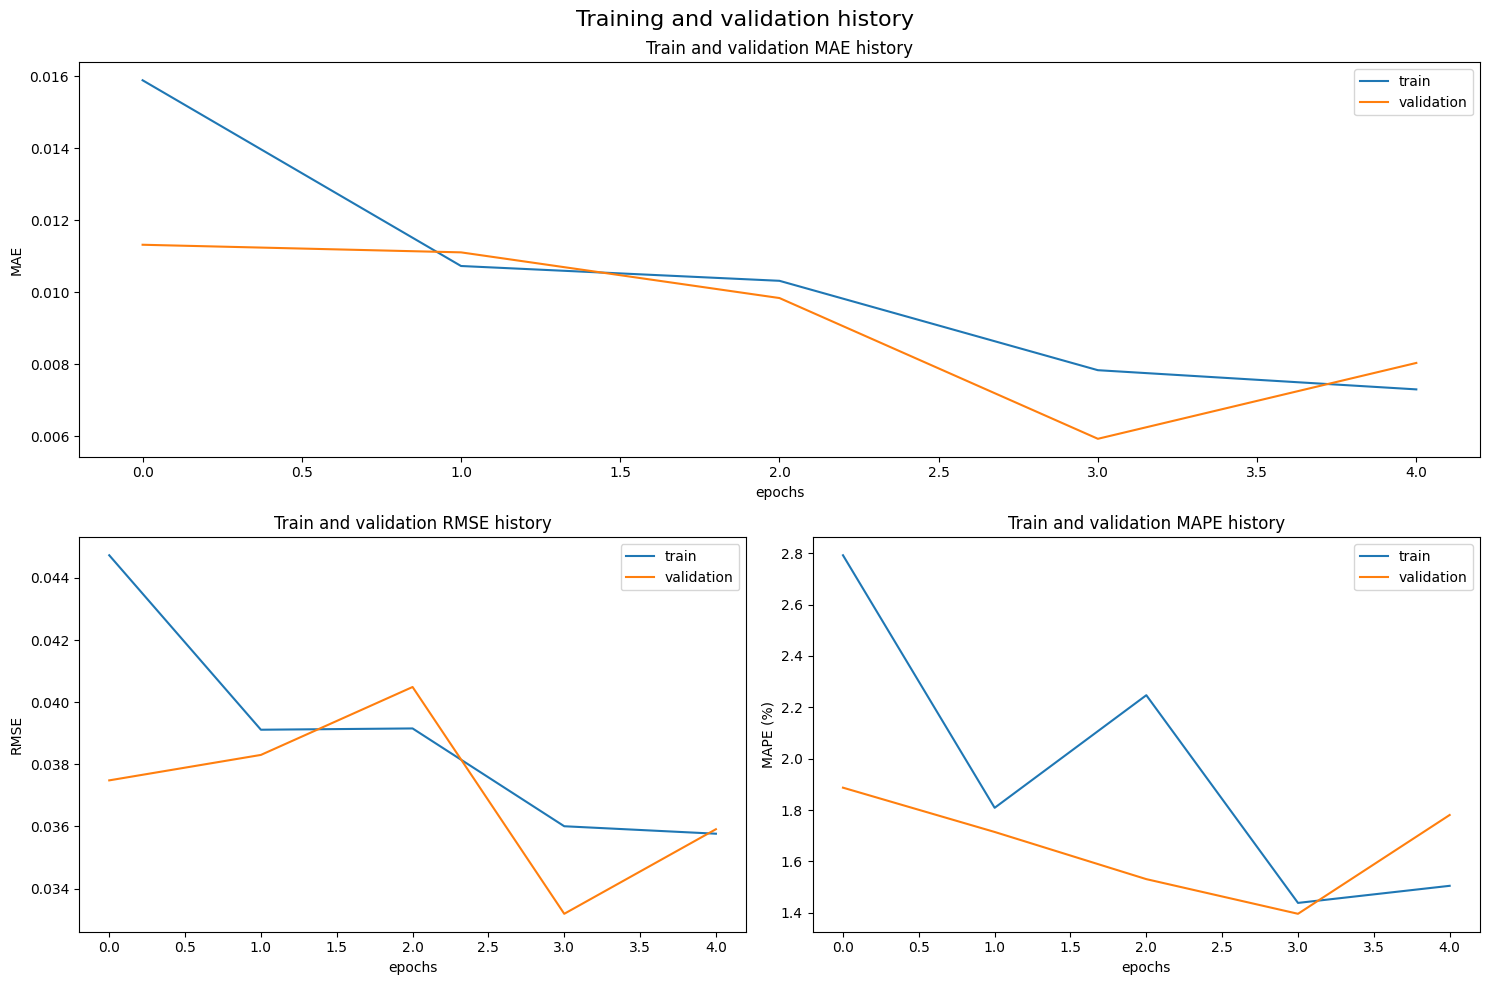

In [22]:
from src.spatial_temporal_gnn.training import plot_training_history

plot_training_history(history)

In [23]:
from src.explanation.navigator.training_redone import validate

test_mae, test_rmse, test_mape = validate(
    model, test_loader, spatial_temporal_gnn, scaler)

print(f'Results on the test set: MAE {test_mae:.3g} - RMSE {test_rmse:.3g}',
      f'- MAPE {test_mape * 100.:.3g} %')

Results on the test set: MAE 0.00739 - RMSE 0.0348 - MAPE 1.35 %


In [ ]:
#next(iter(train_loader))[3].shape

In [ ]:
x, ev, t, y = next(iter(train_loader))

In [ ]:
t_repeated = t.unsqueeze(0).repeat(ev.shape[0], 1).to(device=DEVICE).float()
res = model(ev.to(DEVICE).float(), t_repeated)


ev_scores = torch.zeros((x.shape[0], x.shape[1], 1))
            
for i, x_ in enumerate(ev):
    timestep = int(x_[0].item()); node = int(x_[1].item())
    ev_scores[timestep, node, 0] = res[i]

In [ ]:
len(torch.unique(ev_scores.sigmoid()))

2463

In [ ]:
for ev in torch.unique(ev_scores.sigmoid()):
    print(ev)

tensor(0.0830, grad_fn=<UnbindBackward0>)
tensor(0.0849, grad_fn=<UnbindBackward0>)
tensor(0.0928, grad_fn=<UnbindBackward0>)
tensor(0.0968, grad_fn=<UnbindBackward0>)
tensor(0.1026, grad_fn=<UnbindBackward0>)
tensor(0.1058, grad_fn=<UnbindBackward0>)
tensor(0.1089, grad_fn=<UnbindBackward0>)
tensor(0.1106, grad_fn=<UnbindBackward0>)
tensor(0.1115, grad_fn=<UnbindBackward0>)
tensor(0.1142, grad_fn=<UnbindBackward0>)
tensor(0.1161, grad_fn=<UnbindBackward0>)
tensor(0.1169, grad_fn=<UnbindBackward0>)
tensor(0.1272, grad_fn=<UnbindBackward0>)
tensor(0.1279, grad_fn=<UnbindBackward0>)
tensor(0.1347, grad_fn=<UnbindBackward0>)
tensor(0.1350, grad_fn=<UnbindBackward0>)
tensor(0.1354, grad_fn=<UnbindBackward0>)
tensor(0.1379, grad_fn=<UnbindBackward0>)
tensor(0.1387, grad_fn=<UnbindBackward0>)
tensor(0.1429, grad_fn=<UnbindBackward0>)
tensor(0.1448, grad_fn=<UnbindBackward0>)
tensor(0.1451, grad_fn=<UnbindBackward0>)
tensor(0.1470, grad_fn=<UnbindBackward0>)
tensor(0.1476, grad_fn=<UnbindBack